In [228]:
# install.packages(c("cowplot", "googleway", "ggplot2", "ggrepel", 
# "ggspatial", "libwgeom", "sf", "rnaturalearth", "rnaturalearthdata"))

install.packages("readr")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [1]:
library(dplyr)
library(ggplot2)
library(boot)
library(stargazer)
library(sandwich)
library(usmap)
library(rio)
library(readr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [2]:
load("covid.rdata")

## Description of the data

I have analyzed how several variables such as percent of people with higher education, and those living in poverty, distance of a county to the coast and the mean temperature in October affect the advent of new COVID-19 cases in the first week of November. 

 “fips” - a numeric code that uniquely identifies each county in the U.S.

 “covid.new.cases” - the number of confirmed new COVID-19 cases in that county between 11/1/20 - 11/7/20

 “total.past.cases” - the total number of confirmed new COVID-19 cases in that county before 11/1/20.

 “pop” - total population of the county.

 “pov” - percent of the population of the county living in poverty.

 “percent.college.ed” - percent of the population of the county who has had any education above high-school.

 “oct.mean.temp” - mean temperature in October 2020 for that county.

 “rep” - a binary variable, with a “1” indicating that the more people in the county are registered as republicans than democrats, and a “0” indicating that more people in the county are registerd as democrats than as republicans.

 “lon” - longitude of the geographic centroid of the county

 “lat” - latitude of the geographic centroid of the county

I have created a dummy variable: small_pop - to identify if the county is near coast or not. After observing all the latitudes and longitutes in the US map, I presupposed that the following indicator variable:

Likewise, the dummy variable to distinguish between small and large counties is based on the US Census Bureau https://www.census.gov/library/stories/2017/10/big-and-small-counties.html. I have approximated population threshold for the small and large populations by presupposing that a county whose population is below 475,000 is reckoned as a small county, while a county's population larger than 475,000 is a densely populated county.

In [3]:
# renamed a few columns
covid1 = covid %>% 
  rename(
    new_cases = covid.new.cases,
    past_cases = total.past.cases,
    percent_coll_ed =  percent.college.ed,
    oct_avtemp = oct.mean.temp,
    new_prop = new.prop,  # new_cases/pop
    past_prop = past.prop) # past_cases/pop

# dummy variable to identify if the county is near coast or not
covid1$near_coast = 0
covid1$near_coast[(covid1$lon > -125 & covid1$lon < -115) | (covid1$lon > -97 & covid1$lon < -67) 
                  & (covid1$lat > 26 & covid1$lat < 45)] = 1

# dummy variables to distinguish between small and large counties
covid1$small_pop = 0
covid1$small_pop[covid1$pop < 475000] = 1

# take the log of the following variables
covid1$log_new_cases = log(covid1$new_cases)
covid1$log_past_cases = log(covid1$past_cases)
covid1$log_pop = log(covid1$pop)

# replace the inf with 0s in the logged variables
covid1$log_new_cases[is.infinite(covid1$log_new_cases)] = 0
covid1$log_past_cases[is.infinite(covid1$log_past_cases)] = 0
covid1$log_pop[is.infinite(covid1$log_pop)] = 0

head(covid1)

,fips,new_cases,past_cases,pop,pov,percent_coll_ed,lon,lat,oct_avtemp,new_prop,past_prop,rep,near_coast,small_pop,log_new_cases,log_past_cases,log_pop
70,2013,59,306,3337,12.5,33.4,-109.49115,35.40509,57,0.01768055,0.09169913,1,0,1,4.077537,5.723585,8.112827
71,2016,71,510,5634,8.1,31.9,-109.76295,31.88631,65,0.01260206,0.09052183,1,0,1,4.262680,6.234411,8.636575
106,4011,764,7688,9498,11.7,40.9,-91.27147,33.83234,65,0.08043799,0.80943356,1,1,1,6.638568,8.947416,9.158837
119,5005,6115,29956,41932,23.0,34.8,-91.92434,36.08622,60,0.14583135,0.71439473,1,1,1,8.718500,10.307485,10.643805
123,5013,501,3076,5189,21.1,27.0,-93.60666,33.23930,65,0.09655040,0.59279245,1,1,1,6.216606,8.031385,8.554296
161,5089,1444,8105,16694,32.0,32.8,-93.41370,35.00456,62,0.08649814,0.48550377,1,1,1,7.275172,9.000236,9.722805


The descriptive statistics that the variables measuring population, new and past cases are highly volatile as their respective standard deviations and ranges are very high. So, it might be approapriate to trannsform those variables to logged values when using them in linear regression models.

In [4]:
stargazer(covid1, type = 'text')


Statistic        N     Mean     St. Dev.    Min    Pctl(25) Pctl(75)    Max   
------------------------------------------------------------------------------
fips            764 32,869.170 13,598.720  2,013   23,010.5 42,083.5  55,053  
new_cases       764 3,252.483  6,040.288     0      656.8   3,201.2   95,248  
past_cases      764 27,173.140 58,226.200    0      3,965    26,064   914,831 
pop             764 44,394.320 87,635.000   169    7,263.5  45,684.8 1,265,843
pov             764   20.060     7.322     2.500    14.875   24.125   47.800  
percent_coll_ed 764   31.877     5.804     12.700   27.700   35.825   57.300  
lon             764  -90.210     12.012   -123.904 -97.335  -80.555   -70.053 
lat             764   39.601     4.358     26.143   37.158   42.599   48.786  
oct_avtemp      764   53.241     8.623       33       47       59       80    
new_prop        764   0.095      0.060     0.000    0.053    0.124     0.463  
past_prop       764   0.619      0.256     0.000   

In [5]:
# Writing covid1 data to a csv file
write_csv(covid1, path = "covid1.csv")

Warning message:
“The `path` argument of `write_csv()` is deprecated as of readr 1.4.0.
Please use the `file` argument instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”

Firstly, I divided the whole dataset into 10 equal small samples to do 10-fold cross validation (CV). So, I have trained my model in 9 of these random samples, and tested the model's performance in the 10th out-of-sample. Performing this procedure iteratively 10 times, corss-validation ensures that the tenth out-of-sample (or the test set) to evaluate the model is unique. Then, I fitted the model with all the variables and employed the Mean Squared Prediction Error (MSPE) as a metric to check the model's performance. It is the CV estimate of the forecast error adjusted for bias arising when we don't resort to leave-one-out-cross validation technique.

Initially, I had created a model with new_cases as the response variable. But upon checking the model diagostics, the residual vs fitted plot indicated heteroskedastic and non-normal errors, that were heavily skewed. So, I transformed the response variable to log_new_cases, and it generates homoskedastic errors. 

The variables past_prop and new_prop are a linear combination of the existing variables: pop, new_cases, and past_cases. So, including past_prop, new_prop, pop, new_cases, and past_cases as separate regressors in the model will create multicollinearity. The regression results outputs extremely significant results and a high R2. The variables might seem to be highly positively correlated and might have a spurious relationship. This also violates the Gauss-Markov assumption of linear independence among the covariates. Thus, the rank may of the design matrix X may not be full, yielding imprecise estimates. Therefore, I have removed past_prop and new_prop from the model as it also maximizes  the precision of the estimates. Correlated regressors also generate biased estimates. The final model is as follows: 

In [6]:
set.seed(123)
model.glm1 = glm(log_new_cases ~ log_past_cases + pov + percent_coll_ed + 
                 oct_avtemp + small_pop + near_coast + rep + lat +lon, data = covid1)
cv.glm(data = covid1, glmfit = model.glm1, K = 10)$delta[2]

[1] 0.1565266

In [8]:
cov = vcovHC(model.glm1, type = "HC")
robust.se = sqrt(diag(cov)) # heteroskedasticity robust standard errors 

stargazer(model.glm1, title="Results", align=TRUE, type = 'text', se=list(robust.se),
column.labels=c("robust"))


Results
                      Dependent variable:    
                  ---------------------------
                         log_new_cases       
                            robust           
---------------------------------------------
log_past_cases             0.893***          
                            (0.013)          
                                             
pov                         0.004**          
                            (0.002)          
                                             
percent_coll_ed             0.007**          
                            (0.003)          
                                             
oct_avtemp                 -0.026***         
                            (0.005)          
                                             
small_pop                  -0.201***         
                            (0.055)          
                                             
near_coast                  0.107**          
                         

In [9]:
exp(0.289) # coeff of rep

[1] 1.335092

In [10]:
1-exp(-0.026) # coeff of oct_avtemp
100*(-0.026) #100⋅β1

[1] 0.02566491

[1] -2.6

In [11]:
1-exp(-0.177) # coeff of near_coast 

[1] 0.1622202

The numbers below the parenthesis represent the heteroskedastic robust standard errors, which are the square root of the diagonal elements of the variance-covariance matrix. All the variables are significant as the p-values < 0.05 significant level. As the response variable is in log scale, I exponentiated the slope coefficients to interpret them in the non-log scale. 

 
Being a member of the Republican party increases the expected geometric mean of new COVID-19 cases by 32.5 percent relative of being a Democratic party. This is because log(beta_rep) = log(0.289) = 1.335.
In other words, the model expects (arithematic mean) the new COVID cases to be 28.9 percent higher for a Republican-dominated county relative to a Democratic county. This is because 100 * slope coeff of rep = 100*(0.289) = 28.9


Rise in average temperature in October by one degree farenheit decreases the number of new cases by 2.6 percent. Therefore, cold temperatures raise the number of COVID cases. This is because 100 * slope coeff of oct_avtemp = 100*(-0.026) = -2.6 


On average counties with small population have 21.8 percent fewer cases than those with large populations, which reflects the reality as well. Densely populated counties reduces the chances of social distancing, propelling the virus to traverse faster among people, increasing the number of cases. 


From the model, counties located near coasts expect a 10.7 percent rise in the number of new cases as opposed to the regions located midwest and other landlocked states. We can likely attribute this to the fact that coastal counties have a higher population density than than those far-inland. The latter have sparser population as they are agricultural and manufacturing hubs. Another reason is because of the relaxed policies as more people don't wear masks, and crowd in huge numbers in public spaces. Most of the in-land states are also Republican dominated, which (based on the trend) are less likely undertake health-safety precautions, further accelerating the number of new cases. Relatedly, latitudes and longitudes, which define the geographic locations are very significant, albeit by a lesser degree. For instance, rise in latitude and longitude by 1 degree, diminishes the percent of new cases by 3.4 and a miniscule 0.5 percent, respectively. 

Likewise, the variables pov and percent_coll_ed have minute although significant affect in altering the new cases. Curiously, when more people in a county have an education level higher than high school, then the new COVID cases rise by 0.7 percent. 

However, the diagnostic plots below indicate very slight non-normality as the residuals tail-off in the lower left end. Even though the points fall along the line in the middle of the graph in the normal Q-Q plots indicate that the there are a few extreme values than we would expect had the data been truly normally distributed.

The clustered residuals in the residualas vs fitted plot still depict heteroskedastic residuals. However, relatove to the preliminary models (not shown) that I has tried, this plot depicts lesser heteroskedasticity. 

The mean-squared prediction error is 0.156. 

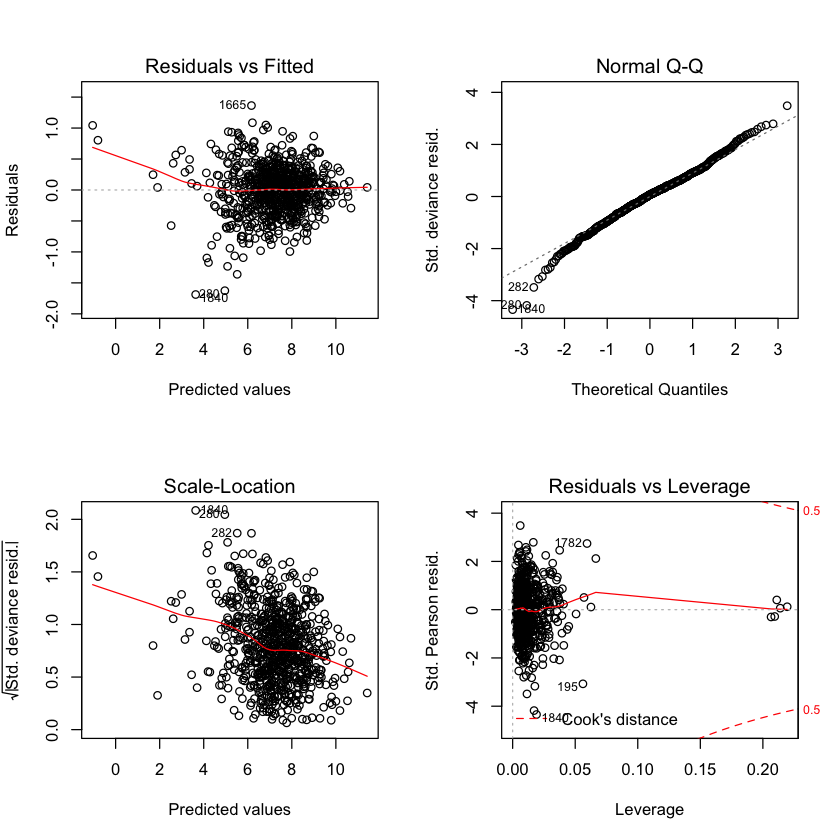

In [12]:
par(mfrow=c(2,2)) # Change the panel layout to 2 x 2
plot(model.glm1)

Below, I have plotted the partial residual plots, which represent the sum of the specific predictor variable and the residuals. The red lines are are the lines of best fit, obtained from regressing the explanatory variable's partial residuals on the variable itself. The dashed red lines are called smooth lowess lines which assess the extent to which the model is non-linear. Since all of the dashed lines almost coincide with the fitted line, the model is linear, and does not require additional polynomial terms. 

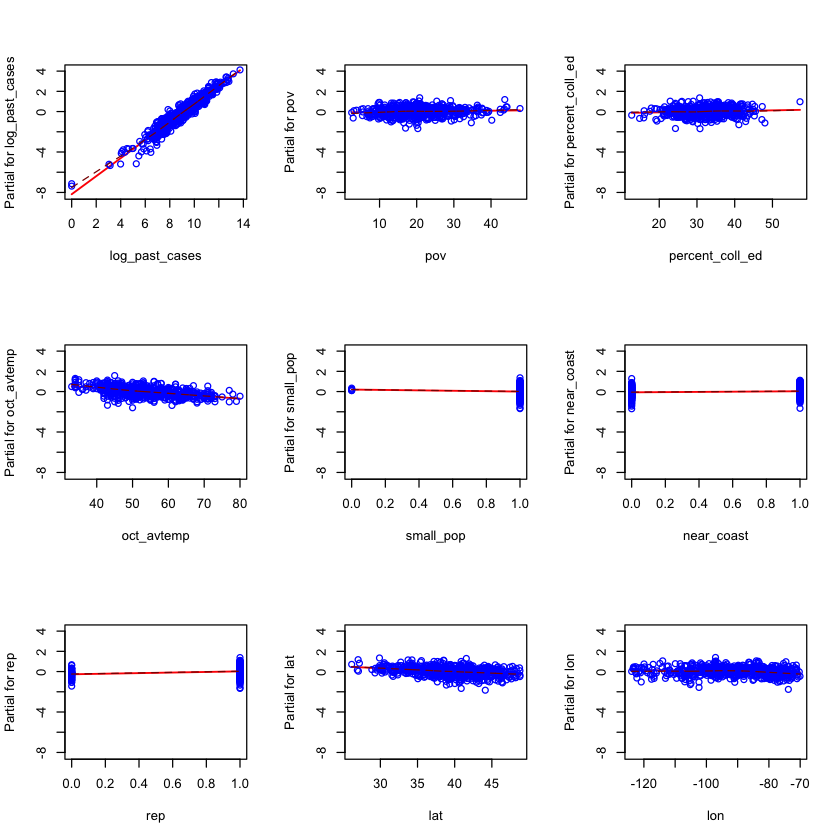

In [13]:
par(mfrow=c(3,3))
termplot(model.glm1, partial.resid=TRUE, col.res = "blue", smooth=panel.smooth)

## References

Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics
Tables. R package version 5.2.2. https://CRAN.R-project.org/package=stargazer

https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqhow-do-i-interpret-a-regression-model-when-some-variables-are-log-transformed/

https://sites.google.com/site/curtiskephart/ta/econ113/interpreting-beta

https://chart-studio.plotly.com/create/#/